In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

C:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|█████████████████████████████████████████████████████████████████████████████| 66.0M/66.0M [00:08<00:00, 8.45MB/s]

Extracting files...


Path to dataset files: C:\Users\ADMIN\.cache\kagglehub\datasets\mlg-ulb\creditcardfraud\versions\3


In [6]:
# Define the path to your dataset file
file_path = "C:/Users/ADMIN/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3/creditcard.csv"

# Load the dataset
df = pd.read_csv(file_path)


In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
# Separate features and labels
X = df.drop('Class', axis=1)  # 'Class' is the label column
y = df['Class']

In [9]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state=2)
X_train_normal = X_train[y_train == 0] # Train only on normal transactions

In [11]:
input_dim = X_train_normal.shape[1]

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)

# Latent space -> This layer outputs the core, compressed representation of the data, held in latent.
latent = Dense(4, activation='relu')(encoded)

# Decoder
decoded = Dense(8, activation='relu')(latent)
decoded = Dense(16, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [13]:
history = autoencoder.fit(X_train_normal, X_train_normal,
                          epochs=10,
                          batch_size=256,
                          validation_split=0.1,
                          shuffle=True)

Epoch 1/10
800/800 [==============================] - 10s 12ms/step - loss: 0.8922 - val_loss: 0.8752
Epoch 2/10
800/800 [==============================] - 9s 12ms/step - loss: 0.8691 - val_loss: 0.8655
Epoch 3/10
800/800 [==============================] - 5s 6ms/step - loss: 0.8604 - val_loss: 0.8580
Epoch 4/10
800/800 [==============================] - 5s 6ms/step - loss: 0.8500 - val_loss: 0.8455
Epoch 5/10
800/800 [==============================] - 6s 7ms/step - loss: 0.8384 - val_loss: 0.8345
Epoch 6/10
800/800 [==============================] - 5s 7ms/step - loss: 0.8299 - val_loss: 0.8283
Epoch 7/10
800/800 [==============================] - 5s 6ms/step - loss: 0.8246 - val_loss: 0.8242
Epoch 8/10
800/800 [==============================] - 6s 7ms/step - loss: 0.8202 - val_loss: 0.8192
Epoch 9/10
800/800 [==============================] - 5s 7ms/step - loss: 0.8161 - val_loss: 0.8158
Epoch 10/10
800/800 [==============================] - 6s 7ms/step - loss: 0.8132 - val_loss: 0.8

In [14]:
# Predict on normal training data
reconstructions = autoencoder.predict(X_train_normal)
reconstruction_errors = np.mean(np.square(reconstructions - X_train_normal), axis=1)

# Define a threshold as, for example, the 95th percentile of reconstruction errors
threshold = np.percentile(reconstruction_errors, 95)
print("Threshold:", threshold)

7108/7108 [==============================] - 32s 4ms/step
Threshold: 1.6441774426092182


In [15]:
# Predict on test data
test_reconstructions = autoencoder.predict(X_test)
test_errors = np.mean(np.square(test_reconstructions - X_test), axis=1)

# Classify based on threshold
y_pred = [1 if error > threshold else 0 for error in test_errors]

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix)

1781/1781 [==============================] - 9s 5ms/step
Accuracy: 94.98%
Confusion Matrix:
 [[54030  2848]
 [    9    75]]


In [16]:
anomalies = test_errors > threshold
# Calculate the number of anomalies
num_anomalies = np.sum(anomalies)
print(f"Number of Anomalies: {num_anomalies}")


Number of Anomalies: 2923


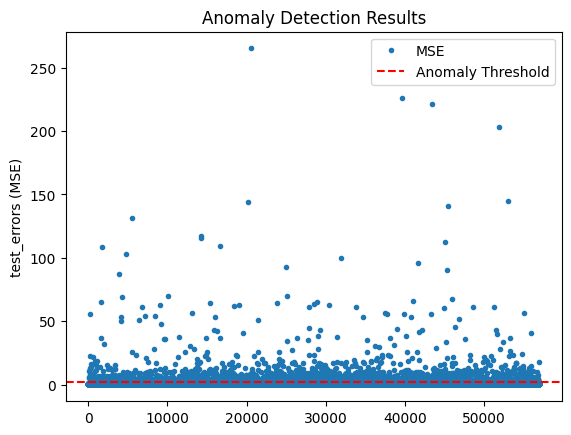

In [17]:
#Plot the anomalies
import matplotlib.pyplot as plt
# plt.figure(figsize=(12, 6))
plt.plot(test_errors, marker='o', linestyle='', markersize=3, label='MSE', )
plt.axhline(threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.ylabel('test_errors (MSE)')
plt.title('Anomaly Detection Results')
plt.legend()
plt.show()

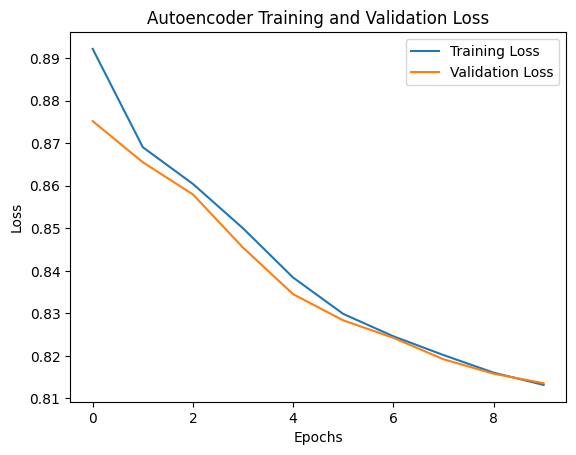

In [18]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Autoencoder Training and Validation Loss')
plt.show()